In [104]:
from pyspark.sql import SQLContext, Row
from pyspark.ml.feature import PCA
from pyspark.mllib.feature import PCA as PCAmllib
from pyspark.mllib.linalg import Vectors
from pyspark import SparkConf, SparkContext
from pyspark.ml.clustering import KMeans
from numpy import array
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


In [105]:
lines = sc.textFile("/home/ubuntu/yi/extracted_features/extracted_features").map(lambda x:x.split(" "))
lines = lines.map(lambda x:(x[0],[float(y) for y in x[1:]]))

In [106]:
def make_heatmap(df):
    adf=df
    #cols=[i for i in asd.columns if 'action' in i]+sorted([i for i in asd.columns if 'action' not in i])
    #cols=sorted([i for i in asd.columns if 'action' not in i])
    #cols.remove('count')
    #cols.remove('prediction')
    cols=sorted([i for i in adf.columns])
    cols.remove('prediction')
    #plotdf=asd[cols]
    #plotdf=plotdf.iloc[:10,:]
    plotdf = adf[cols]
    plt.rcParams.update({'font.size': 2})
    #plt.figure(figsize=(10, 10))
    #cmap = sns.cubehelix_palette(dark=1,light=.3, as_cmap=True)
    cmap=sns.light_palette("red", as_cmap=True)
    fig, ax = plt.subplots()
    ax = sns.heatmap(((plotdf - plotdf.mean()) / (plotdf.max() - plotdf.min())).T \
                     ,cbar=True,xticklabels=range(0,20),linewidths=.5, vmin=-1,vmax=1,annot=True,fmt=".2g",annot_kws={"size": 20})#,cmap=cmap)
    #ax.ticklabel_format
    plt.xlabel('Cluster',size=20)
    plt.ylabel('User-Level Features (Averages)',size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    fig.set_figwidth(25)
    fig.set_figheight(10)
    #fig.savefig('foo'+str(j)+'.png',figsize=(105,20))
    #print j
    #from IPython.display import Image
    #Image(filename='foo.png') 
    pass

In [107]:
df = lines.map(lambda x: Row(labels=x[0],features=Vectors.dense(x[1]))).toDF()

In [108]:
kmeans = KMeans(k=20, seed=1,initSteps=5, tol=1e-4, maxIter=20, initMode="k-means||", featuresCol="features")
model = kmeans.fit(df)


In [109]:
import re
output_path = "/home/ubuntu/yi/extracted_features"
outputfile = open(output_path + '/cluster_data', 'w')
inputfile = open(output_path + '/clusterFeatures/kmeans20_Data', 'r')
for line in inputfile:
      x = line.split("=")[3].split("'")[1] + " "
      x += line.split("=")[2].split(",")[0]
      
      outputfile.write(x+'\n')
inputfile.close()
outputfile.close()

In [110]:
kmFeatures = model.transform(df).select("features", "prediction","labels")

In [112]:
from pyspark.sql.functions import udf,lit
from pyspark.sql.types import DoubleType,IntegerType

def give_value(vector,idx):
    return float(vector[idx])
    

give_value_udf=udf(give_value,DoubleType())



In [113]:
kmFeatures=kmFeatures.withColumn('ads_pattern',give_value_udf(kmFeatures.features,lit(0)))
kmFeatures=kmFeatures.withColumn('ext_link',give_value_udf(kmFeatures.features,lit(1)))

In [114]:
kmGroup = kmFeatures.groupBy("prediction").agg({'ads_pattern':'avg','ext_link':'avg','prediction':'count'}).show()

+----------+-----------------+------------------+------------------+
|prediction|count(prediction)|     avg(ext_link)|  avg(ads_pattern)|
+----------+-----------------+------------------+------------------+
|         0|               15|             290.8|137.33333333333334|
|         1|             4801|0.5988335763382628|0.5457196417413039|
|         2|                7| 662.2857142857143| 43.57142857142857|
|         3|              574| 9.893728222996515| 40.72996515679443|
|         4|               24|            238.75|29.541666666666668|
|         5|                3|            1087.0|2.3333333333333335|
|         6|                2|              12.5|             657.0|
|         7|              106|111.19811320754717| 14.30188679245283|
|         8|             1141| 6.530236634531113| 19.44609991235758|
|         9|               50|             11.26|            144.28|
|        10|                2|            1545.0|               1.0|
|        11|              679|25.5

In [115]:
import seaborn as sns; sns.set()

In [116]:
p=kmFeatures.groupBy("prediction").agg({'ads_pattern':'avg','ext_link':'avg','prediction':'count'}).toPandas()

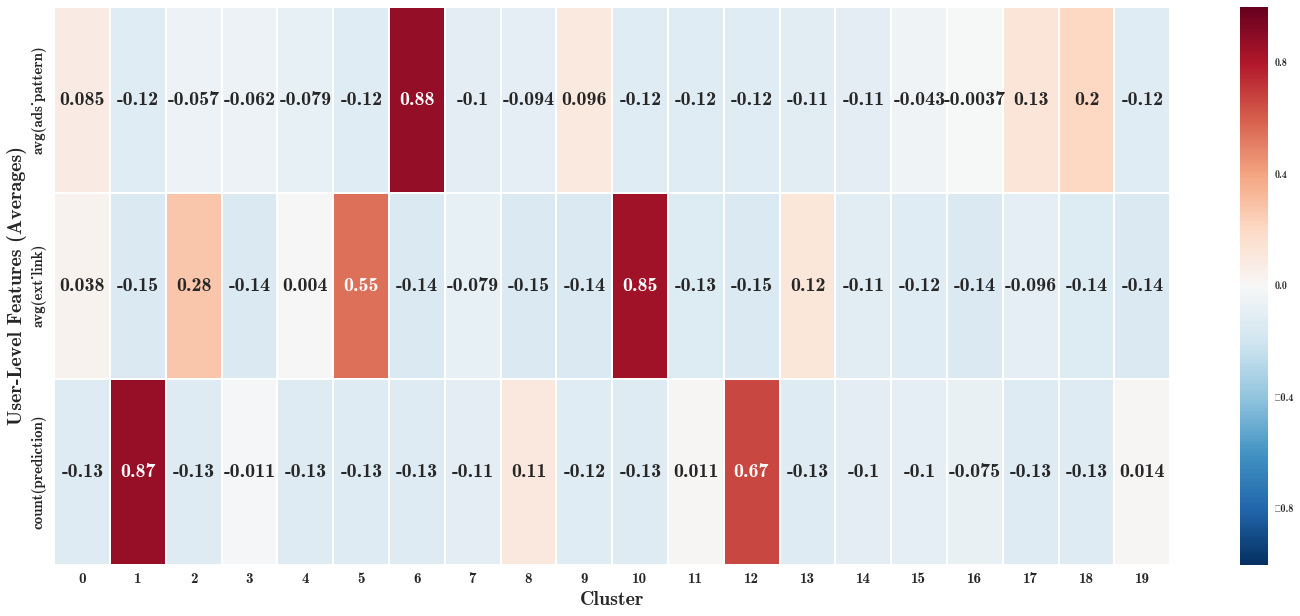

In [117]:
make_heatmap(p)

In [118]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
#kmFeatures = kmFeatures.withColumnRenamed('labels','file_name')
def give_label(prediction):
    if prediction in (0,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18):
        return float(1)
    return float(0)
    

give_label_udf=udf(give_label,DoubleType())
kmFeatures=kmFeatures.withColumn('label',give_label_udf(kmFeatures.prediction))
kmFeatures.show()

+-----------+----------+--------------+-----------+--------+-----+
|   features|prediction|        labels|ads_pattern|ext_link|label|
+-----------+----------+--------------+-----------+--------+-----+
|  [0.0,0.0]|         1|     amazon875|        0.0|     0.0|  0.0|
| [12.0,4.0]|         8|     moviecli4|       12.0|     4.0|  1.0|
|  [0.0,0.0]|         1|      tumblr20|        0.0|     0.0|  0.0|
| [4.0,14.0]|        19|      reddit43|        4.0|    14.0|  0.0|
|[14.0,15.0]|         8|   tallahassee|       14.0|    15.0|  1.0|
|  [9.0,1.0]|         1|    glassdoor3|        9.0|     1.0|  0.0|
|  [0.0,3.0]|         1|inboxdollars78|        0.0|     3.0|  0.0|
|  [5.0,1.0]|         1|       zillow8|        5.0|     1.0|  0.0|
|  [0.0,0.0]|         1|       delta33|        0.0|     0.0|  0.0|
|  [0.0,9.0]|        12|        msn172|        0.0|     9.0|  0.0|
| [0.0,15.0]|        19|inboxdollars42|        0.0|    15.0|  0.0|
|  [0.0,0.0]|         1|         pof45|        0.0|     0.0|  

In [145]:
kmFeatures.groupBy("label").count().show()
labelData = kmFeatures.drop('prediction').show()


+-----+-----+
|label|count|
+-----+-----+
|  1.0| 3194|
|  0.0| 9336|
+-----+-----+

+-----------+--------------+-----------+--------+-----+
|   features|        labels|ads_pattern|ext_link|label|
+-----------+--------------+-----------+--------+-----+
|  [0.0,0.0]|     amazon875|        0.0|     0.0|  0.0|
| [12.0,4.0]|     moviecli4|       12.0|     4.0|  1.0|
|  [0.0,0.0]|      tumblr20|        0.0|     0.0|  0.0|
| [4.0,14.0]|      reddit43|        4.0|    14.0|  0.0|
|[14.0,15.0]|   tallahassee|       14.0|    15.0|  1.0|
|  [9.0,1.0]|    glassdoor3|        9.0|     1.0|  0.0|
|  [0.0,3.0]|inboxdollars78|        0.0|     3.0|  0.0|
|  [5.0,1.0]|       zillow8|        5.0|     1.0|  0.0|
|  [0.0,0.0]|       delta33|        0.0|     0.0|  0.0|
|  [0.0,9.0]|        msn172|        0.0|     9.0|  0.0|
| [0.0,15.0]|inboxdollars42|        0.0|    15.0|  0.0|
|  [0.0,0.0]|         pof45|        0.0|     0.0|  0.0|
|[56.0,10.0]|      newsmax3|       56.0|    10.0|  1.0|
|  [0.0,1.0]|   twi

In [192]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#lr = LogisticRegression(maxIter=10, regParam=0.01)
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [10]).addGrid(lr.regParam, [0.01,0.05,1.00,2.00])\
.addGrid(lr.threshold, [0.5,0.6,0.7,0.8,0.9]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, numFolds=10, estimatorParamMaps=grid, evaluator=evaluator)

In [ ]:
cvModel = cv.fit(labelData)
evaluator.evaluate(cvModel.transform(labelData))

In [173]:
cvModel.bestModel.intercept

-2.5426423499654764

In [97]:
training, test = labelData.randomSplit([0.7, 0.3])
lr_model = lr.fit(training)

In [129]:
result = lr_model.transform(test).head()
output = lr_model.transform(test)

In [144]:
result.prediction
result.probability
result.rawPrediction

DenseVector([2.6019, -2.6019])

In [130]:
output.show()

+---------+---------+-----------+--------+-----+--------------------+--------------------+----------+
| features|   labels|ads_pattern|ext_link|label|       rawPrediction|         probability|prediction|
+---------+---------+-----------+--------+-----+--------------------+--------------------+----------+
|[0.0,0.0]|      aaa|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim0|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim1|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim2|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|   amazon|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|amazon109|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|amazon127|        0.0|     0.0|  0.0|[2.60191106312927...|[0.9309844712

In [131]:
output = output.withColumnRenamed('labels','file_name')

In [132]:
output.show()

+---------+---------+-----------+--------+-----+--------------------+--------------------+----------+
| features|file_name|ads_pattern|ext_link|label|       rawPrediction|         probability|prediction|
+---------+---------+-----------+--------+-----+--------------------+--------------------+----------+
|[0.0,0.0]|      aaa|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim0|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim1|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|     aim2|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|   amazon|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|amazon109|        0.0|     0.0|  0.0|[2.60191106312927...|[0.93098447120251...|       0.0|
|[0.0,0.0]|amazon127|        0.0|     0.0|  0.0|[2.60191106312927...|[0.9309844712

In [135]:
tp=output.filter(output.label==1).filter(output.prediction==output.label).count()
fn=output.filter(output.label==1).filter(output.prediction!=output.label).count()
tn=output.filter(output.label==0).filter(output.prediction==output.label).count()
fp=output.filter(output.label==0).filter(output.prediction!=output.label).count()

In [141]:
sensitivity = tp/float(tp+fn)*100
sensitivity

67.098703888335

In [142]:
specificity = tn/float(tn+fp)*100
specificity

100.0

In [196]:
#########DOWN SAMPLING#########
down_labelData = labelData.filter(labelData.label==0).sample(False,0.34) \
.unionAll(labelData.filter(labelData.label==1).sample(True,1.0))
down_labelData.show()
d_training, d_test = down_labelData.randomSplit([0.7, 0.3])

+----------+--------------+-----------+--------+-----+
|  features|        labels|ads_pattern|ext_link|label|
+----------+--------------+-----------+--------+-----+
| [0.0,0.0]|     amazon875|        0.0|     0.0|  0.0|
|[4.0,14.0]|      reddit43|        4.0|    14.0|  0.0|
| [0.0,3.0]|inboxdollars78|        0.0|     3.0|  0.0|
| [5.0,1.0]|       zillow8|        5.0|     1.0|  0.0|
| [0.0,0.0]|       delta33|        0.0|     0.0|  0.0|
| [0.0,9.0]|        msn172|        0.0|     9.0|  0.0|
|[0.0,15.0]|inboxdollars42|        0.0|    15.0|  0.0|
| [0.0,0.0]|         pof45|        0.0|     0.0|  0.0|
| [0.0,1.0]|   twinspires3|        0.0|     1.0|  0.0|
| [0.0,0.0]|   priceline27|        0.0|     0.0|  0.0|
| [0.0,0.0]|        bjpenn|        0.0|     0.0|  0.0|
| [0.0,0.0]|       delta26|        0.0|     0.0|  0.0|
| [0.0,5.0]|      bestbuy8|        0.0|     5.0|  0.0|
| [0.0,0.0]|     amazon735|        0.0|     0.0|  0.0|
| [0.0,2.0]|      charter6|        0.0|     2.0|  0.0|
| [0.0,1.0

In [197]:
cvModel = cv.fit(d_training)
evaluator.evaluate(cvModel.transform(d_training))

0.9911684377824703

In [198]:
d_output = cvModel.transform(d_test)

In [175]:
lr_model = lr.fit(d_training)
d_result = lr_model.transform(d_test).head()
d_output = lr_model.transform(d_test)

In [199]:
d_tp=d_output.filter(d_output.label==1).filter(d_output.prediction==d_output.label).count()
d_fn=d_output.filter(d_output.label==1).filter(d_output.prediction!=d_output.label).count()
d_tn=d_output.filter(d_output.label==0).filter(d_output.prediction==d_output.label).count()
d_fp=d_output.filter(d_output.label==0).filter(d_output.prediction!=d_output.label).count()

In [200]:
d_sensitivity = d_tp/float(d_tp+d_fn)*100
d_sensitivity

81.81818181818183

In [201]:
d_specificity = d_tn/float(d_tn+d_fp)*100
d_specificity

99.48293691830403

In [202]:
#########UP SAMPLING#########
up_labelData = labelData.filter(labelData.label==0).sample(False,1.0) \
.unionAll(labelData.filter(labelData.label==1).sample(True,2.92))
up_labelData.show()
u_training, u_test = up_labelData.randomSplit([0.7, 0.3])

+----------+--------------+-----------+--------+-----+
|  features|        labels|ads_pattern|ext_link|label|
+----------+--------------+-----------+--------+-----+
| [0.0,0.0]|     amazon875|        0.0|     0.0|  0.0|
| [0.0,0.0]|      tumblr20|        0.0|     0.0|  0.0|
|[4.0,14.0]|      reddit43|        4.0|    14.0|  0.0|
| [9.0,1.0]|    glassdoor3|        9.0|     1.0|  0.0|
| [0.0,3.0]|inboxdollars78|        0.0|     3.0|  0.0|
| [5.0,1.0]|       zillow8|        5.0|     1.0|  0.0|
| [0.0,0.0]|       delta33|        0.0|     0.0|  0.0|
| [0.0,9.0]|        msn172|        0.0|     9.0|  0.0|
|[0.0,15.0]|inboxdollars42|        0.0|    15.0|  0.0|
| [0.0,0.0]|         pof45|        0.0|     0.0|  0.0|
| [0.0,1.0]|   twinspires3|        0.0|     1.0|  0.0|
| [0.0,0.0]|   priceline27|        0.0|     0.0|  0.0|
| [0.0,0.0]|        bjpenn|        0.0|     0.0|  0.0|
| [0.0,0.0]|       delta26|        0.0|     0.0|  0.0|
| [0.0,5.0]|      bestbuy8|        0.0|     5.0|  0.0|
| [8.0,8.0

In [203]:
cvModel = cv.fit(u_training)
evaluator.evaluate(cvModel.transform(u_training))

0.9898224860268854

In [ ]:
u_output = cvModel.bestModelbestModel.transform(u_test)

In [187]:
u_training, u_test = up_labelData.randomSplit([0.7, 0.3])
lr_model = lr.fit(u_training)
u_result = lr_model.transform(u_test).head()
u_output = lr_model.transform(u_test)

AttributeError: 'LogisticRegressionModel' object has no attribute 'fit'

In [188]:
u_output = cvModel.bestModel.transform(u_test)

In [204]:
u_tp=u_output.filter(u_output.label==1).filter(u_output.prediction==u_output.label).count()
u_fn=u_output.filter(u_output.label==1).filter(u_output.prediction!=u_output.label).count()
u_tn=u_output.filter(u_output.label==0).filter(u_output.prediction==u_output.label).count()
u_fp=u_output.filter(u_output.label==0).filter(u_output.prediction!=u_output.label).count()

In [205]:
u_sensitivity = u_tp/float(u_tp+u_fn)*100
u_sensitivity

81.23268698060942

In [206]:
u_specificity = u_tn/float(u_tn+u_fp)*100
u_specificity

99.4731296101159